In [14]:
import torch.optim as optim
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

In [15]:
dataset = load_dataset("garythung/trashnet")
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5054
    })
})

<Figure size 640x480 with 0 Axes>

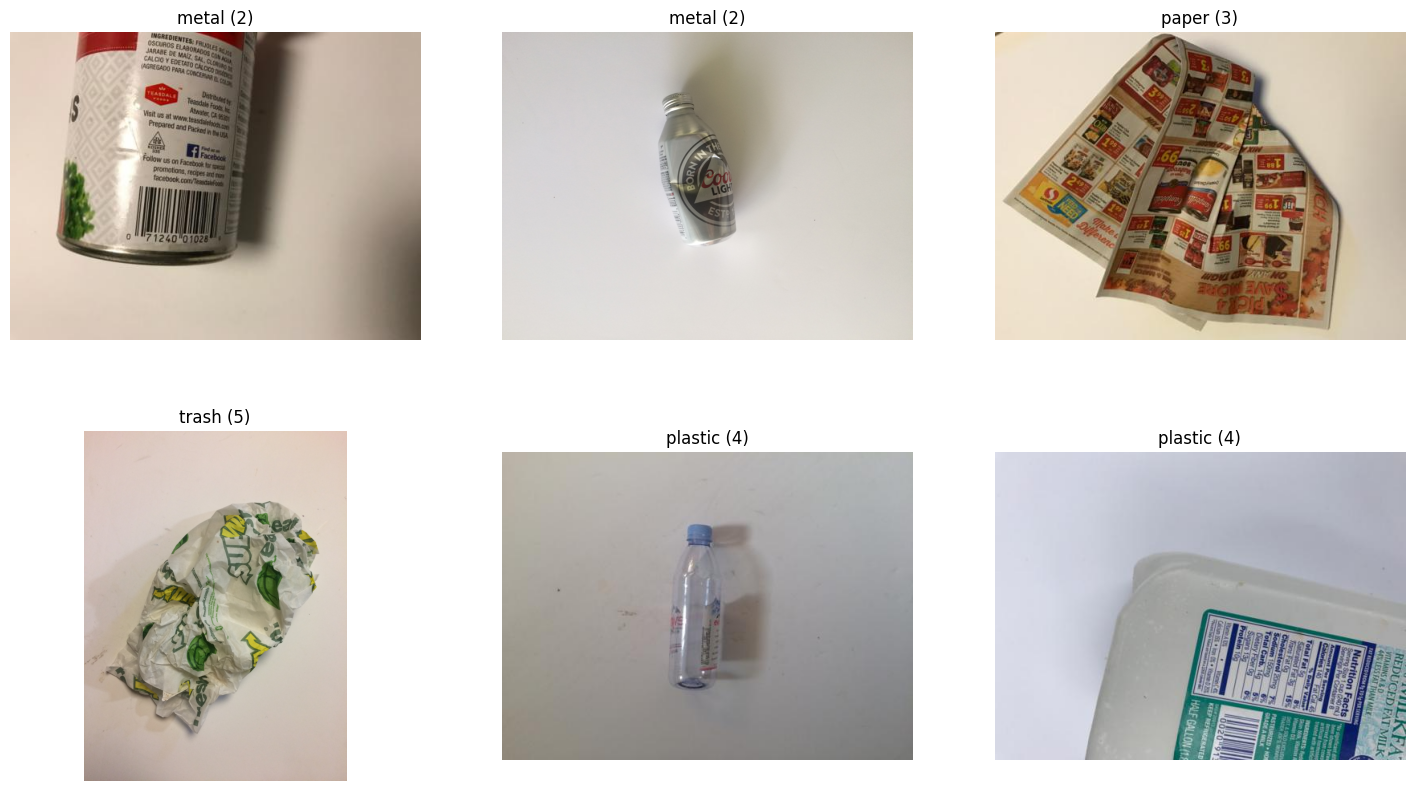

In [16]:
labels = {
    0: "cardboard",
    1: "glass",
    2: "metal",
    3: "paper",
    4: "plastic",
    5: "trash"
}

def display_random(dataset, num_images=4):
    rows = 2
    cols = np.ceil(num_images / rows).astype(int)

    plt.figure(figsize=(18, 10))
    indices = np.random.choice(range(len(dataset)), size=num_images, replace=False)

    for i, idx in enumerate(indices, 1):
        idx = int(idx)
        image = dataset[idx]['image']
        label = dataset[idx]['label']
        label_name = labels.get(label, "Unknown")

        plt.subplot(rows, cols, i)
        plt.imshow(image)
        plt.title(f"{label_name} ({label})")
        plt.axis('off')

plt.tight_layout()
plt.show()

display_random(dataset['train'], num_images=6)

In [17]:
class TrashnetDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']

        if self.transform:
            image = self.transform(image)

        return image, label
    
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Flip Horizontal
    transforms.RandomRotation(15),      # Rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Brighhtness and Contrast
    transforms.Resize((224, 224)),      # Resize
    transforms.ToTensor(),              # Tensorize
])

In [18]:
dataset_size = len(dataset['train'])

train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size 

train_data, val_data = random_split(dataset['train'], [train_size, val_size])

train_dataset = TrashnetDataset(train_data, transform=transform)
val_dataset = TrashnetDataset(val_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [19]:
class TrashnetModel(torch.nn.Module):
    def __init__(self, num_classes):
        super(TrashnetModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  
        self.fc2 = nn.Linear(128, num_classes) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 64 * 56 * 56)  
        x = F.relu(self.fc1(x))      
        x = self.fc2(x)            
        return x 

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TrashnetModel(torch.nn.Module):
    def __init__(self, num_classes):
        super(TrashnetModel, self).__init__()
        
        # Increased initial channels and added batch normalization
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Second conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Third conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [21]:
num_classes = len(set(dataset['train']['label'])) 

model = TrashnetModel(num_classes)

In [22]:
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001) 

# Number of epochs
epochs = 2

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in tqdm(range(epochs)):
    # --- Training Phase ---
    model.train() 
    running_train_loss = 0.0
    correct_train, total_train = 0, 0

    for images, labels in train_loader:
        images, labels = images, labels

        # Forward prop
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss
        running_train_loss += loss.item()

        # training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # traning stats
    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # --- Validation Phase ---
    model.eval()  
    running_val_loss = 0.0
    correct_val, total_val = 0, 0

    with torch.no_grad():  
        for images, labels in val_loader: 
            images, labels = images, labels

            # Forward prop
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Loss
            running_val_loss += loss.item()

            # Validation accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()


100%|██████████| 2/2 [59:57<00:00, 1798.70s/it]


In [23]:
epoch_val_loss = running_val_loss / len(val_loader)
epoch_val_accuracy = 100 * correct_val / total_val
val_losses.append(epoch_val_loss)
val_accuracies.append(epoch_val_accuracy)

print(f"Epoch [{epoch+1}/{epochs}]")
print(f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%")
print(f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.2f}%\n")

Epoch [2/2]
Train Loss: 1.3217, Train Accuracy: 48.11%
Validation Loss: 1.5411, Validation Accuracy: 48.66%



In [ ]:
# Switch to evaluation mode
model.eval()

correct, total = 0, 0

with torch.no_grad(): 
    for images, labels in train_loader:  
        images, labels = images, labels

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f1804ec3b30>>
Traceback (most recent call last):
  File "/home/soic/.local/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [62]:
torch.save(model.state_dict(), '../models/cnn_1.pth')
print("Model parameters saved!")

Model parameters saved!
